# Spooky Author Identification <a class='tocSkip'>

<img src='https://raw.githubusercontent.com/spacecadet84/spooky_author_id/master/images/authors.jpg'>

# Introduction

This project will identify the authors of text excerpts using natural language processing. It will also serve as my initial entry into Kaggle's natural language contest of the same name. The authors include Edgar Allen Poe, HP Lovecraft and Mary Shelley. We'll start by exploring the structure of the data, then clean up any inconsistencies and creating a few visualizations before feeding the data into our algorithm. Let's dive in!

# Load Modules

In [66]:
# Data Manipulation
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', 200)
from IPython.display import display

# Visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
colors = sns.color_palette()
import missingno as msno

import json

# Natural Language Processing
import re
from google.cloud import language
from textblob import TextBlob as tb
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import os

# Load Data

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)

# Authorizations

In [6]:
# Google Language API
google_auth = json.load(open('data/google_auth.json', 'r'))
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "data/google_auth.json"

# Data Structure

In [7]:
display(train_df.shape)
display(train_df.info())
display(train_df.describe())
display(train_df.describe(include=['O']))

(19579, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
id        19579 non-null object
text      19579 non-null object
author    19579 non-null object
dtypes: object(3)
memory usage: 459.0+ KB


None

,id,text,author
count,19579,19579,19579
unique,19579,19579,3
top,id07303,"I escaped from them to the room where lay the body of Elizabeth, my love, my wife, so lately living, so dear, so worthy.",EAP
freq,1,1,7900


,id,text,author
count,19579,19579,19579
unique,19579,19579,3
top,id07303,"I escaped from them to the room where lay the body of Elizabeth, my love, my wife, so lately living, so dear, so worthy.",EAP
freq,1,1,7900


# Data Cleaning

The unicode characters aren't playing nicely with tb. Let's convert them to ascii strings for now. If we're losing important data, we'll convert it back later.

In [ ]:
train_df.text = train_df.text.str.decode('utf-8', 'ignore')

# Visualizations

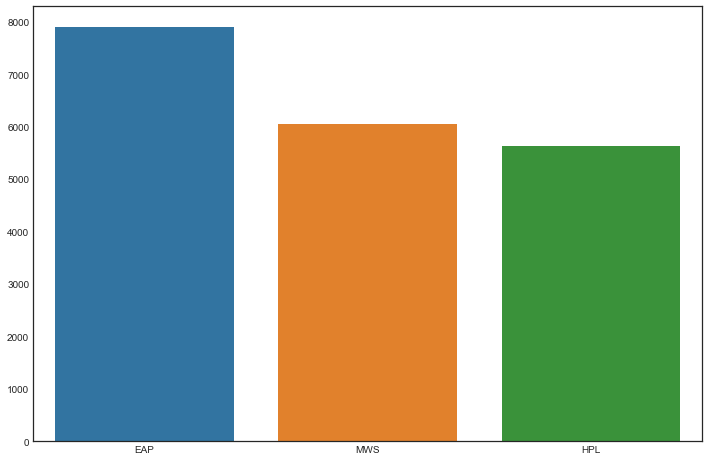

In [43]:
#plt.figure(figsize=(12,8))
author_counts = train_df.author.value_counts()
sns.barplot(x=author_counts.index, y=author_counts.values)
plt.show()

In [36]:
train_df['word_count'] = train_df.text.apply(lambda x: len(tb(x).words))

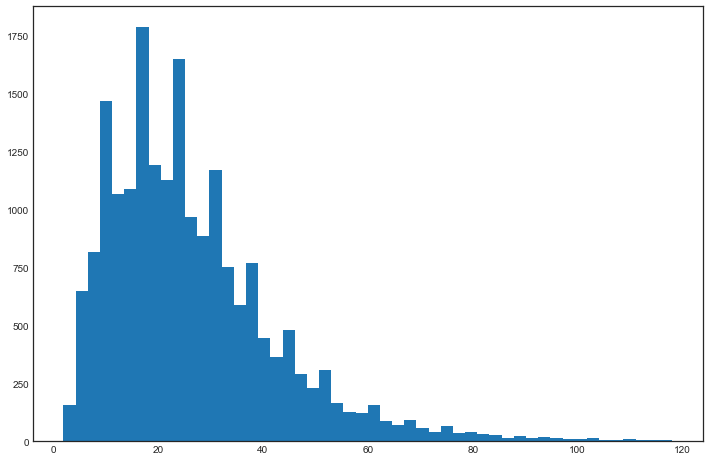

In [49]:
plt.hist(train_df[train_df.word_count<120].word_count, bins=50)
plt.show()

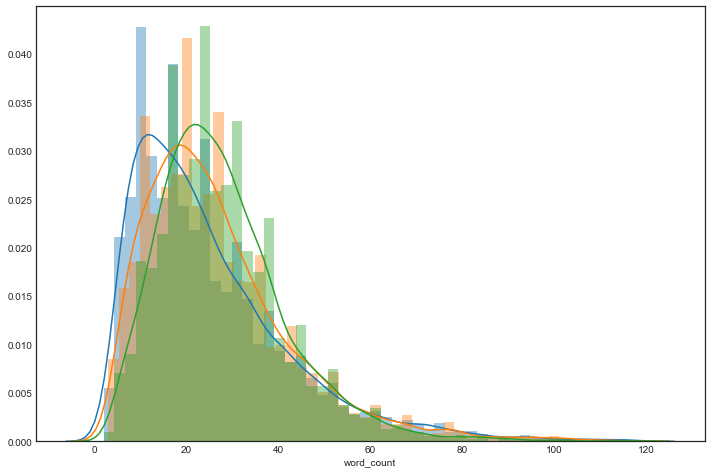

In [50]:
sns.distplot(
    train_df[(train_df.author=='EAP') & (train_df.word_count<120)].word_count,
    color=colors[0]
)
sns.distplot(
    train_df[(train_df.author=='MWS') & (train_df.word_count<120)].word_count,
    color=colors[1]
)
sns.distplot(
    train_df[(train_df.author=='HPL') & (train_df.word_count<120)].word_count,
    color=colors[2]
)
plt.show()

# Modeling

## Stem Words

Our first step will be to convert our words into stem words.

In [55]:
def get_stems(text):
    words = tb(text).words
    stemmer = SnowballStemmer("english")
    stems = []
    if len(words)>0:
        for word in words:
            stems.append(stemmer.stem(word))
    return " ".join(stems)
        

In [ ]:
def get_words(text):
    return tb()

In [57]:
train_df['stems'] = train_df.text.apply(get_stems)

In [74]:
train_df['words'] = train_df.text.apply(lambda x: " ".join(tb(x).words))

In [75]:
train_df.head()

,id,text,author,word_count,stems,words
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so...",EAP,41,this process howev afford me no mean of ascertain the dimens of my dungeon as i might make it circuit and return to the point whenc i set out without be awar of the fact so perfect uniform seem th...,This process however afforded me no means of ascertaining the dimensions of my dungeon as I might make its circuit and return to the point whence I set out without being aware of the fact so perfe...
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL,14,it never onc occur to me that the fumbl might be a mere mistak,It never once occurred to me that the fumbling might be a mere mistake
2,id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfact...",EAP,36,in his left hand was a gold snuff box from which as he caper down the hill cut all manner of fantast step he took snuff incess with an air of the greatest possibl self satisfact,In his left hand was a gold snuff box from which as he capered down the hill cutting all manner of fantastic steps he took snuff incessantly with an air of the greatest possible self satisfaction
3,id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering...",MWS,34,how love is spring as we look from windsor terrac on the sixteen fertil counti spread beneath speckl by happi cottag and wealthier town all look as in former year heart cheer and fair,How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath speckled by happy cottages and wealthier towns all looked as in former years heart cheering an...
4,id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL,27,find noth els not even gold the superintend abandon his attempt but a perplex look occasion steal over his counten as he sit think at his desk,Finding nothing else not even gold the Superintendent abandoned his attempts but a perplexed look occasionally steals over his countenance as he sits thinking at his desk


## Unigram Vectorization

### With Stemming

In [61]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(train_df.stems)
vectors.shape

(19579, 15130)

In [62]:
x_train, x_test, y_train, y_test = train_test_split(vectors, train_df.author, test_size=.3, random_state=42)

In [65]:
svm = LinearSVC()
svm.fit(x_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [67]:
pred = svm.predict(x_test)
accuracy_score(pred, y_test)

0.82277834525


### Without Stemming

In [76]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(train_df.words)
vectors.shape

(19579, 25053)

In [77]:
x_train, x_test, y_train, y_test = train_test_split(vectors, train_df.author, test_size=.3, random_state=42)

In [78]:
svm = LinearSVC()
svm.fit(x_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [79]:
pred = svm.predict(x_test)
accuracy_score(pred, y_test)

0.825842696629


## Bigram Vectorization

### With Stemming

In [69]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5)
vectors = vectorizer.fit_transform(train_df.stems)
vectors.shape

(19579, 20467)


In [70]:
x_train, x_test, y_train, y_test = train_test_split(vectors, train_df.author, test_size=.3, random_state=42)

In [71]:
svm = LinearSVC()
svm.fit(x_train, y_train)

pred = svm.predict(x_test)
accuracy_score(pred, y_test)

0.828226081035


### Without Stemming

In [80]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5)
vectors = vectorizer.fit_transform(train_df.words)
vectors.shape

(19579, 21209)


In [81]:
x_train, x_test, y_train, y_test = train_test_split(vectors, train_df.author, test_size=.3, random_state=42)

In [82]:
svm = LinearSVC()
svm.fit(x_train, y_train)

pred = svm.predict(x_test)
accuracy_score(pred, y_test)

0.828226081035


# Conclusions

Overall, this was a great first step. The 83% accuracy achieved here is not phenomenal but it is a great baseline from which to improve and was accomplished in a few short lines of code! Next steps will include preparing this for submission and iterating on our process. Thanks for taking the time to read this!

#

#

#